# Phase 9 — Walk-Forward Backtest (Rolling Refit)

Monthly walk-forward: train up to each month-end, predict the next month, roll.
Compares to the static (Phase 7) backtest under the same fees.


In [126]:
# --- Imports & params ---
from pathlib import Path
import json, math
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

DATA = Path("data")
ART  = Path("artifacts")
FIG  = Path("reports/figures")
FIG.mkdir(parents=True, exist_ok=True)

# Fees/slippage in basis points per turnover (same idea as Phase 7)
FEE_BPS      = 5.0
SLIPPAGE_BPS = 0.0

# Threshold (τ) – use artifacts if present, else default
if (ART/"threshold.json").exists():
    try:
        TAU = float(json.load(open(ART/"threshold.json"))["LR"]["tau"])
    except Exception:
        TAU = 0.52
else:
    TAU = 0.52

print("Using τ =", TAU, "| Fees (bps):", FEE_BPS, "| Slippage (bps):", SLIPPAGE_BPS)


Using τ = 0.54 | Fees (bps): 5.0 | Slippage (bps): 0.0


In [127]:
# --- Load Phase-2 dataset and prep features/labels ---
base_csv = DATA/"df_nb02.csv"
assert base_csv.exists(), "Missing data/df_nb02.csv (run Notebook 02)"

df = pd.read_csv(base_csv)

# datetime + sort
assert "date" in df.columns, "Expected a date column in df_nb02.csv"
df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.tz_localize(None)
df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

# label
label_col = next((c for c in ["y","target","label","y_next_up"] if c in df.columns), None)
assert label_col is not None, "No label column (expected one of y/target/label/y_next_up)"
y = df[label_col].astype(int).reset_index(drop=True)

# Non-features to drop
drop_cols = [label_col, "date", "ticker", "symbol", "spy_close", "vix_close"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# Numeric only
X = X.select_dtypes(include=[np.number]).copy().fillna(0.0)

print("Shape:", X.shape, "| label:", y.shape, "| dates:", df["date"].min().date(), "→", df["date"].max().date())


Shape: (2078, 14) | label: (2078,) | dates: 2015-02-20 → 2023-12-28


In [128]:
# --- Cell 3.5: drop leaks & rebuild features/labels (NEXT-DAY target) ---

# 1) Build today's return series and NEXT-DAY label
ret_col_candidates = ["ret1", "daily_ret", "r1"]
ret_col = next((c for c in ret_col_candidates if c in df.columns), None)
if ret_col is None:
    price_col = next((c for c in ["close","Close","adj_close","Adj Close"] if c in df.columns), None)
    px = df[["date", price_col]].dropna().sort_values("date").copy()
    px["ret1"] = px[price_col].pct_change().fillna(0.0)
    ret_today = px.set_index("date")["ret1"]
else:
    ret_today = df.set_index("date")[ret_col].astype(float)

df = df.copy()
df["ret_mkt_today"] = df["date"].map(ret_today).fillna(0.0)
y = (df["ret_mkt_today"].shift(-1) > 0).astype(int).reset_index(drop=True)

# 2) Drop obvious non-features + discovered leaks
LEAKY_COLS = {"ret_next", "y", "target", "label", "y_next_up"}  # add others if you find them
drop_cols = {
    "date","ticker","symbol","spy_close","vix_close",
    # same-day realized returns / helpers
    "ret1","daily_ret","r1","ret_mkt_today",
}
drop_cols |= LEAKY_COLS

# 3) Rebuild X
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
X = X.select_dtypes(include=[np.number]).fillna(0.0).copy()
print("Final features:", X.shape[1], "| rows:", len(X), "| dropped:", sorted(list(LEAKY_COLS & set(df.columns))))


Final features: 12 | rows: 2078 | dropped: ['ret_next', 'y']


In [129]:
# --- Build monthly folds: (train_end -> test_month) ---
# train on all data up to month m (inclusive), test on month m+1
dts = df["date"]
month = dts.dt.to_period("M")

unique_months = pd.PeriodIndex(month.unique()).sort_values()
# Skip first few months so train has some data
min_train_months = 12  # at least 1 year of training before first test
folds = []

for i in range(min_train_months, len(unique_months)-1):
    train_last = unique_months[i]       # inclusive
    test_m     = unique_months[i+1]     # next month
    train_idx  = month <= train_last
    test_idx   = month == test_m
    if test_idx.sum() == 0:
        continue
    folds.append((train_idx.values, test_idx.values, str(test_m)))

assert len(folds) > 0, "Not enough history to form folds (need >12 months)."
print("Folds:", len(folds), "| first test month:", folds[0][2], "| last:", folds[-1][2])


Folds: 94 | first test month: 2016-03 | last: 2023-12


In [130]:
# --- Walk-forward: fit LogisticRegression each fold, predict next month ---
probs, trues, dates, month_tag = [], [], [], []
positions = []  # for threshold strategy
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, n_jobs=None))

for tr_idx, te_idx, tag in folds:
    X_tr, X_te = X.iloc[tr_idx].values, X.iloc[te_idx].values
    y_tr, y_te = y.iloc[tr_idx].values, y.iloc[te_idx].values
    d_te       = df.loc[te_idx, "date"].values

    # Fit
    pipeline.fit(X_tr, y_tr)

    # Predict proba on test month
    p = pipeline.predict_proba(X_te)[:,1]
    probs.append(p)
    trues.append(y_te)
    dates.append(d_te)
    month_tag.extend([tag]*len(p))

    # Thresholded positions (long-only)
    positions.append((p > TAU).astype(int))

# concat
p_all   = np.concatenate(probs) if probs else np.array([])
y_all   = np.concatenate(trues) if trues else np.array([])
d_all   = pd.to_datetime(np.concatenate(dates)) if dates else pd.to_datetime([])
pos_all = np.concatenate(positions) if positions else np.array([])

wf = pd.DataFrame({"date": d_all, "y": y_all, "prob": p_all, "pos": pos_all, "month": month_tag})
wf = wf.sort_values("date").reset_index(drop=True)
print(wf.shape)
wf.head()


(1830, 5)


,date,y,prob,pos,month
0,2016-03-01,1,0.304473,0,2016-03
1,2016-03-02,1,0.462227,0,2016-03
2,2016-03-03,1,0.406477,0,2016-03
3,2016-03-04,0,0.327133,0,2016-03
4,2016-03-07,1,0.434881,0,2016-03


In [131]:
# --- Compute realized daily return and strategy equity ---
# We need the underlying ticker daily returns aligned to df dates.
# Reuse the baseline daily return from Phase-2 if present, else compute from 'close' columns if they exist.

ret_col_candidates = ["ret1", "daily_ret", "r1"]  # if you had a single-day return in nb02
ret_col = next((c for c in ret_col_candidates if c in df.columns), None)

if ret_col is None:
    # Try to reconstruct simple daily return from a 'close' price if exists
    price_col = next((c for c in ["close","Close","adj_close","Adj Close"] if c in df.columns), None)
    assert price_col is not None, "Need a daily return column (ret1) or a close price in df_nb02.csv to compute returns."
    px = df[["date", price_col]].dropna().sort_values("date")
    px["ret1"] = px[price_col].pct_change().fillna(0.0)
    ret_series = px.set_index("date")["ret1"]
else:
    ret_series = df.set_index("date")[ret_col].astype(float)

wf["ret_mkt"] = wf["date"].map(ret_series).fillna(0.0).values

# Strategy return = position(t-1) * ret_mkt(t) minus fees on turnover
wf["pos_prev"] = wf["pos"].shift(1).fillna(0.0)
turnover = (wf["pos"] - wf["pos_prev"]).abs()
fee_rate = (FEE_BPS + SLIPPAGE_BPS) / 1e4  # convert bps to fraction
wf["ret_strat"] = wf["pos_prev"] * wf["ret_mkt"] - fee_rate * turnover

# Equity curves
wf["eq_mkt"]   = (1.0 + wf["ret_mkt"]).cumprod()
wf["eq_strat"] = (1.0 + wf["ret_strat"]).cumprod()

print("Turnover (avg):", float(turnover.mean().round(4)), "| Final equity:",
      float(wf["eq_strat"].iloc[-1].round(3)) if len(wf) else "N/A")
wf.tail(3)


Turnover (avg): 0.1585 | Final equity: 1.166


,date,y,prob,pos,month,ret_mkt,pos_prev,ret_strat,eq_mkt,eq_strat
1827,2023-12-22,1,0.510959,0,2023-12,-0.005547,0.0,-0.0,7.741525,1.16576
1828,2023-12-27,1,0.513632,0,2023-12,0.000518,0.0,0.0,7.745534,1.16576
1829,2023-12-28,0,0.508878,0,2023-12,0.002226,0.0,0.0,7.762778,1.16576


In [135]:
# --- Quick τ sweep on existing predictions (no retrain) ---
import numpy as np, pandas as pd, math

def sharpe_annualized(r):
    r = pd.Series(r).dropna()
    s = r.std(ddof=0)
    if len(r) < 5 or not np.isfinite(s) or s < 1e-6: return np.nan
    return float((r.mean() / s) * np.sqrt(252))

def summarize_with_tau(df_in, tau):
    df = df_in.copy()
    pos_prev = df["pos"].copy()  # keep for turnover if you prefer fold boundaries; we’ll recompute fresh
    df["pos"] = (df["prob"] > tau).astype(float)
    df["pos_prev"] = df["pos"].shift(1).fillna(0.0)
    turnover = (df["pos"] - df["pos_prev"]).abs()
    fee_rate = (FEE_BPS + SLIPPAGE_BPS)/1e4
    df["ret_strat_tau"] = df["pos_prev"]*df["ret_mkt"] - fee_rate*turnover
    eq = (1+df["ret_strat_tau"]).cumprod()
    peak = eq.cummax()
    mdd = float(((eq/peak)-1).min())
    vol_a = float(df["ret_strat_tau"].std(ddof=0) * math.sqrt(252))
    total_ret = float(eq.iloc[-1]-1)
    sharpe = sharpe_annualized(df["ret_strat_tau"])
    return dict(tau=tau,
                pos_rate=float(df["pos"].mean()),
                turnover=float(turnover.mean()),
                Sharpe=sharpe, vol_annual=vol_a,
                total_return=total_ret, max_drawdown=mdd)

taus = [0.54, 0.52, 0.51, 0.50, 0.49]
rows = [summarize_with_tau(wf.copy(), t) for t in taus]
pd.DataFrame(rows)


,tau,pos_rate,turnover,Sharpe,vol_annual,total_return,max_drawdown
0,0.54,0.383607,0.158470,0.206298,0.205875,0.165760,-0.459247
1,0.52,0.574863,0.135519,0.358940,0.242119,0.518017,-0.426353
2,0.51,0.659563,0.113661,0.352570,0.251865,0.512161,-0.407123
3,0.50,0.731148,0.090164,0.560450,0.266302,1.283832,-0.412094
4,0.49,0.772678,0.071585,0.678365,0.273059,1.926433,-0.366190


In [132]:
# --- Metrics (stable) ---
import numpy as np
import pandas as pd
import math

def sharpe_annualized(r):
    r = pd.Series(r).dropna()
    if len(r) < 5:
        return np.nan
    s = r.std(ddof=0)
    if not np.isfinite(s) or s < 1e-6:
        return np.nan
    return float((r.mean() / s) * np.sqrt(252))

def summarize(returns, dates):
    r = pd.Series(returns).dropna().astype(float)
    if r.empty:
        return dict(CAGR=np.nan, Sharpe=np.nan, vol_annual=np.nan,
                    total_return=np.nan, max_drawdown=np.nan)
    eq = (1 + r).cumprod()
    total_ret = float(eq.iloc[-1] - 1)
    vol_a = float(r.std(ddof=0) * math.sqrt(252))
    sharpe = sharpe_annualized(r)
    # drawdown
    peak = eq.cummax()
    mdd = float(((eq/peak) - 1.0).min())
    # CAGR
    dts = pd.to_datetime(dates)
    span_days = (dts.max() - dts.min()).days or 1
    years = span_days / 365.0
    cagr = float(eq.iloc[-1]**(1/years) - 1) if years > 0 else np.nan
    return dict(CAGR=cagr, Sharpe=sharpe, vol_annual=vol_a,
                total_return=total_ret, max_drawdown=mdd)

overall = summarize(wf["ret_strat"], wf["date"])
overall

# Per-month metrics (Sharpe NA if month is near-flat)
by_m = wf.groupby("month", sort=False)
per_month = pd.DataFrame({
    "AUC": by_m.apply(lambda g: (roc_auc_score(g["y"], g["prob"])
                                 if g["y"].nunique()>1 else np.nan)),
    "Sharpe": by_m.apply(lambda g: sharpe_annualized(g["ret_strat"])),
    "TotalReturn": by_m.apply(lambda g: (1+g["ret_strat"]).prod()-1),
    "N": by_m.size()
}).reset_index()

per_month.head()


C:\Users\ybh11\AppData\Local\Temp\ipykernel_8340\1965916579.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "AUC": by_m.apply(lambda g: (roc_auc_score(g["y"], g["prob"])
C:\Users\ybh11\AppData\Local\Temp\ipykernel_8340\1965916579.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "Sharpe": by_m.apply(lambda g: sharpe_annualized(g["ret_strat"])),
C:\Users\ybh11\AppData\Local\Temp\ipykernel_8340\1965916579.py:44

,month,AUC,Sharpe,TotalReturn,N
0,2016-03,0.654762,NaN,0.000000,19
1,2016-04,0.450549,-5.669551,-0.050155,20
2,2016-05,0.666667,2.631509,0.032323,19
3,2016-06,0.545455,-1.920846,-0.015598,21
4,2016-07,0.513889,5.766433,0.013881,17


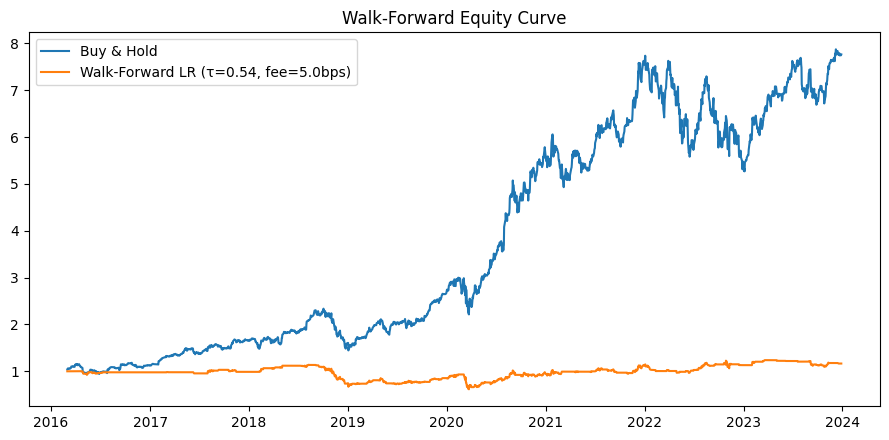

Saved: reports\figures\equity_curve_walkforward.png | data\walkforward_metrics.csv | artifacts\walkforward_summary.json


In [133]:
# --- Plot equity vs market; save artifacts ---
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd

# Figure
plt.figure(figsize=(9, 4.5))
plt.plot(wf["date"], wf["eq_mkt"],   label="Buy & Hold")
plt.plot(wf["date"], wf["eq_strat"], label=f"Walk-Forward LR (τ={TAU:.2f}, fee={FEE_BPS}bps)")
plt.title("Walk-Forward Equity Curve")
plt.legend()
plt.tight_layout()

out_fig = FIG / "equity_curve_walkforward.png"
out_fig.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_fig, dpi=150)
plt.show()

# Save per-month metrics
out_csv = DATA / "walkforward_metrics.csv"
per_month.to_csv(out_csv, index=False)

# Save overall summary
summary = {
    "fee_bps": float(FEE_BPS),
    "slippage_bps": float(SLIPPAGE_BPS),
    "tau": float(TAU),
    "overall": {k: (None if pd.isna(v) else float(v)) for k, v in overall.items()},
    "rows": int(len(wf)),
    "start": (None if len(wf) == 0 else str(pd.to_datetime(wf["date"]).min())),
    "end":   (None if len(wf) == 0 else str(pd.to_datetime(wf["date"]).max())),
}
out_json = ART / "walkforward_summary.json"
out_json.parent.mkdir(parents=True, exist_ok=True)
json.dump(summary, open(out_json, "w"), indent=2)

print("Saved:", out_fig, "|", out_csv, "|", out_json)


In [134]:
# --- Sanity report ---
import pandas as pd
print("Overall walk-forward:")
print(pd.Series(overall).round(4))

print("\nHead of per-month metrics:")
display(per_month.head(10).style.format({"AUC":"{:.3f}", "Sharpe":"{:.2f}", "TotalReturn":"{:.2%}"}))

print("\nQuick sanity stats:")
print("y rate:", round(float(wf["y"].mean()), 3))
print("prob mean/std:", round(float(wf["prob"].mean()), 3), "/", round(float(wf["prob"].std()), 3))
print("pos rate (τ):", round(float(wf["pos"].mean()), 3))
print("rows:", len(wf), "| span:", wf["date"].min().date(), "→", wf["date"].max().date())


Overall walk-forward:
CAGR            0.0198
Sharpe          0.2063
vol_annual      0.2059
total_return    0.1658
max_drawdown   -0.4592
dtype: float64

Head of per-month metrics:


,month,AUC,Sharpe,TotalReturn,N
0,2016-03,0.655,nan,0.00%,19
1,2016-04,0.451,-5.67,-5.02%,20
2,2016-05,0.667,2.63,3.23%,19
3,2016-06,0.545,-1.92,-1.56%,21
4,2016-07,0.514,5.77,1.39%,17
5,2016-08,0.540,nan,0.00%,20
6,2016-09,0.625,nan,0.00%,18
7,2016-10,0.750,nan,0.00%,17
8,2016-11,0.686,nan,0.00%,17
9,2016-12,0.431,nan,0.00%,18



Quick sanity stats:
y rate: 0.537
prob mean/std: 0.525 / 0.072
pos rate (τ): 0.384
rows: 1830 | span: 2016-03-01 → 2023-12-28
